<a href="https://colab.research.google.com/github/tangweize/tf_learning/blob/main/site/zh-cn/tutorials/load_data/csv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 加载 CSV 数据

## 安装

In [65]:
import pandas as pd
import numpy as np
# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers

## 混合数据类型

"Titanic" 数据集包含有关泰坦尼克号乘客的信息。该数据集的名义任务是预测幸存者。

![交通堵塞。](https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/load_data/images/csv/traffic.jpg?raw=1)

图片[来自 Wikimedia](https://commons.wikimedia.org/wiki/File:Trafficjam.jpg)

原始数据可以轻松加载为 Pandas `DataFrame`，但不能立即用作 TensorFlow 模型的输入。


In [66]:
titanic = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [81]:
titanic_features = titanic.copy()
titanic_labels = titanic_features.pop('survived')

In [88]:
inputs = {}
for name, column in titanic_features.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)
inputs

{'sex': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=sex>,
 'age': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=age>,
 'n_siblings_spouses': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=n_siblings_spouses>,
 'parch': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=parch>,
 'fare': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=fare>,
 'class': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=class>,
 'deck': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=deck>,
 'embark_town': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=embark_town>,
 'alone': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=alone>}

预处理逻辑的第一步是将数值输入串联在一起，并通过归一化层运行它们：

In [92]:
numeric_inputs = {name:input for name, input in inputs.items()
 if input.dtype == tf.float32}
x = layers.Concatenate()(list(numeric_inputs.values()))
norm = layers.Normalization()
norm.adapt(np.array(titanic[numeric_inputs.keys()]))
all_numertic_features = norm(x)
all_numertic_features

<KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_85>

In [93]:
preprocessed_inputs = [all_numertic_features]
for name,input in inputs.items():
  if input.dtype != object:
    continue

  lookup = layers.StringLookup(vocabulary=np.unique(titanic[name].values))
  onehot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size)

  x = lookup(x)
  x = onehot(x)
  preprocessed_inputs.append(x)

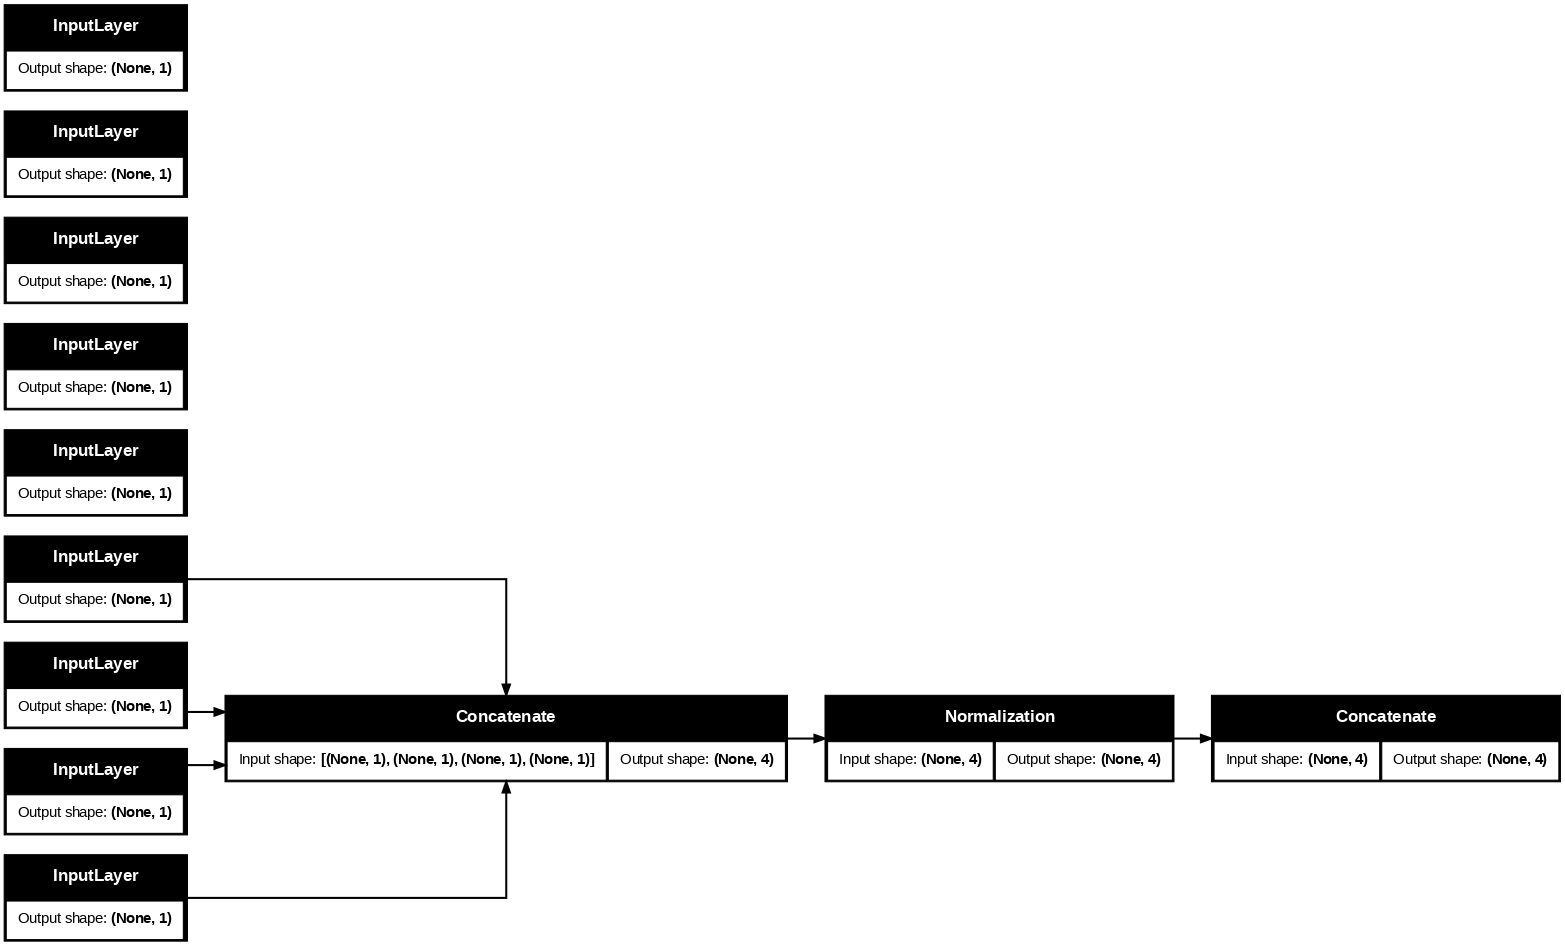

In [95]:
preprocessing_model = layers.Concatenate()(preprocessed_inputs)

titanic_preprocessing =tf.keras.Model(inputs, preprocessing_model)
tf.keras.utils.plot_model(model = titanic_preprocessing, rankdir='LR',dpi = 75,
                         show_shapes=True )

收集所有符号预处理结果，稍后将它们串联起来：

您可以使用 `inputs` 和 `processed_inputs` 的集合将所有预处理的输入串联在一起，并构建处理预处理的模型：

In [ ]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

titanic_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(model = titanic_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

此 `model` 仅包含输入预处理。您可以运行它以查看其对您的数据进行了哪些操作。Keras 模型不会自动转换 Pandas <code>DataFrames</code>，因为不清楚是应该将其转换为一个张量还是张量字典。因此，将其转换为张量字典：

In [ ]:
titanic_features_dict = {name: np.array(value)
                         for name, value in titanic_features.items()}

切出第一个训练样本并将其传递给此预处理模型，您会看到数字特征和字符串独热全部串联在一起：

In [ ]:
features_dict = {name:values[:1] for name, values in titanic_features_dict.items()}
titanic_preprocessing(features_dict)

接下来，在此基础上构建模型：

In [ ]:
def titanic_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam())
  return model

titanic_model = titanic_model(titanic_preprocessing, inputs)

训练模型时，将特征字典作为 `x` 传递，将标签作为 `y` 传递。

In [ ]:
titanic_model.fit(x=titanic_features_dict, y=titanic_labels, epochs=10)

由于预处理是模型的一部分，您可以保存模型并将其重新加载到其他地方并获得相同的结果：

In [ ]:
titanic_model.save('test.keras')
reloaded = tf.keras.models.load_model('test.keras')

In [ ]:
features_dict = {name:values[:1] for name, values in titanic_features_dict.items()}

before = titanic_model(features_dict)
after = reloaded(features_dict)
assert (before-after)<1e-3
print(before)
print(after)

## 使用 tf.data


在前一部分中，您在训练模型时依赖了模型的内置数据乱序和批处理。

如果您需要对输入数据流水线进行更多控制或需要使用不易放入内存的数据：请使用 `tf.data`。

有关更多示例，请参阅 [`tf.data`：构建 TensorFlow 输入流水线](../../guide/data.ipynb)指南。

### 有关内存数据

作为将 `tf.data` 应用于 CSV 数据的第一个样本，请考虑使用以下代码手动切分上一个部分中的特征字典。对于每个索引，它会为每个特征获取该索引：


In [ ]:
import itertools

def slices(features):
  for i in itertools.count():
    # For each feature take index `i`
    example = {name:values[i] for name, values in features.items()}
    yield example

运行此代码并打印第一个样本：

In [ ]:
for example in slices(titanic_features_dict):
  for name, value in example.items():
    print(f"{name:19s}: {value}")
  break

内存数据加载程序中最基本的 `tf.data.Dataset` 是 `Dataset.from_tensor_slices` 构造函数。这会返回一个 `tf.data.Dataset`，它将在 TensorFlow 中实现上述 `slices` 函数的泛化版本。

In [ ]:
features_ds = tf.data.Dataset.from_tensor_slices(titanic_features_dict)

您可以像任何其他 Python 可迭代对象一样迭代 `tf.data.Dataset`：

In [ ]:
for example in features_ds:
  for name, value in example.items():
    print(f"{name:19s}: {value}")
  break

`from_tensor_slices` 函数可以处理嵌套字典或元组的任何结构。以下代码创建了一个 `(features_dict, labels)` 对的数据集：

In [ ]:
titanic_ds = tf.data.Dataset.from_tensor_slices((titanic_features_dict, titanic_labels))

要使用此 `Dataset` 训练模型，您至少需要对数据进行 `shuffle` 和 `batch`。

In [ ]:
titanic_batches = titanic_ds.shuffle(len(titanic_labels)).batch(32)

不是将 `features` 和 `labels` 传递给 `Model.fit`，而是传递数据集：

In [ ]:
titanic_model.fit(titanic_batches, epochs=5)

### 从单个文件

到目前为止，本教程已经使用了内存数据。`tf.data` 是用于构建数据流水线的高度可扩展的工具包，并提供了一些用于处理加载 CSV 文件的函数。

In [ ]:
titanic_file_path = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")

现在，从文件中读取 CSV 数据并创建一个 `tf.data.Dataset`。

（有关完整文档，请参阅 `tf.data.experimental.make_csv_dataset`）


In [ ]:
titanic_csv_ds = tf.data.experimental.make_csv_dataset(
    titanic_file_path,
    batch_size=5, # Artificially small to make examples easier to show.
    label_name='survived',
    num_epochs=1,
    ignore_errors=True,)

此函数包括许多方便的功能，因此很容易处理数据。这包括：

- 使用列标题作为字典键。
- 自动确定每列的类型。

小心：请确保在 `tf.data.experimental.make_csv_dataset` 中设置 `num_epochs` 参数，否则 `tf.data.Dataset` 的默认行为是无限循环。

In [ ]:
for batch, label in titanic_csv_ds.take(1):
  for key, value in batch.items():
    print(f"{key:20s}: {value}")
  print()
  print(f"{'label':20s}: {label}")

注：如果您运行两次上述代码单元，它将产生不同的结果。`tf.data.experimental.make_csv_dataset` 的默认设置包括 `shuffle_buffer_size=1000`，这对于这个小型数据集来说已经绰绰有余，但可能不适用于实际的数据集。

它还可以对数据进行即时解压。下面是一个用 gzip 压缩的 CSV 文件，其中包含 [Metro Interstate Traffic Dataset](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume)。

![字体](https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/load_data/images/csv/fonts.jpg?raw=1)

图片[来自 Wikimedia](https://commons.wikimedia.org/wiki/File:Trafficjam.jpg)


In [ ]:
traffic_volume_csv_gz = tf.keras.utils.get_file(
    'Metro_Interstate_Traffic_Volume.csv.gz',
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz",
    cache_dir='.', cache_subdir='traffic')

将 `compression_type` 参数设置为直接从压缩文件中读取：

In [ ]:
traffic_volume_csv_gz_ds = tf.data.experimental.make_csv_dataset(
    traffic_volume_csv_gz,
    batch_size=256,
    label_name='traffic_volume',
    num_epochs=1,
    compression_type="GZIP")

for batch, label in traffic_volume_csv_gz_ds.take(1):
  for key, value in batch.items():
    print(f"{key:20s}: {value[:5]}")
  print()
  print(f"{'label':20s}: {label[:5]}")

注：如果需要在 `tf.data` 流水线中解析这些日期时间字符串，您可以使用 `tfa.text.parse_time`。

### 缓存

解析 CSV 数据有一些开销。对于小型模型，这可能是训练的瓶颈。

根据您的用例，使用 `Dataset.cache` 或 `tf.data.Dataset.snapshot` 可能是个好主意，这样 CSV 数据仅会在第一个周期进行解析。

`cache` 和 `snapshot` 方法的主要区别在于 `cache` 文件只能由创建它们的 TensorFlow 进程使用，而 `snapshot` 文件可以被其他进程读取。

例如，在没有缓存的情况下迭代 `traffic_volume_csv_gz_ds` 20 次可能需要大约 15 秒，而使用缓存大约需要 2 秒。

In [ ]:
%%time
for i, (batch, label) in enumerate(traffic_volume_csv_gz_ds.repeat(20)):
  if i % 40 == 0:
    print('.', end='')
print()

注：`Dataset.cache` 会存储第一个周期的数据并按顺序回放。因此，使用 `cache` 方法会停用流水线中较早的任何重排。下面，在 `Dataset.cache` 之后重新添加了 `Dataset.shuffle`。

In [ ]:
%%time
caching = traffic_volume_csv_gz_ds.cache().shuffle(1000)

for i, (batch, label) in enumerate(caching.shuffle(1000).repeat(20)):
  if i % 40 == 0:
    print('.', end='')
print()

注：`tf.data.Dataset.snapshot` 文件用于在使用时*临时*存储数据集。这*不是*长期存储的格式。文件格式被视为内部详细信息，无法在 TensorFlow 各版本之间保证。

In [ ]:
%%time
snapshotting = traffic_volume_csv_gz_ds.snapshot('titanic.tfsnap').shuffle(1000)

for i, (batch, label) in enumerate(snapshotting.shuffle(1000).repeat(20)):
  if i % 40 == 0:
    print('.', end='')
print()

如果加载 CSV 文件减慢了数据加载速度，并且 `Dataset.cache` 和 `tf.data.Dataset.snapshot` 不足以满足您的用例，请考虑将数据重新编码为更简化的格式。

### 多个文件

到目前为止，本部分中的所有示例都可以在没有 `tf.data` 的情况下轻松完成。处理文件集合时，`tf.data` 可以真正简化事情。

例如，将 [Character Font Images](https://archive.ics.uci.edu/ml/datasets/Character+Font+Images) 数据集作为 CSV 文件的集合分发，每种字体一个集合。

![Fonts](https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/load_data/images/csv/fonts.jpg?raw=true)

图像作者：<a href="https://pixabay.com/users/wilhei-883152/?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=705667">Willi Heidelbach</a>，来源：<a href="https://pixabay.com/?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=705667">Pixabay</a>

下载数据集，并检查里面的文件：

In [ ]:
fonts_zip = tf.keras.utils.get_file(
    'fonts.zip',  "https://archive.ics.uci.edu/ml/machine-learning-databases/00417/fonts.zip",
    cache_dir='.', cache_subdir='fonts',
    extract=True)

In [ ]:
import pathlib
font_csvs =  sorted(str(p) for p in pathlib.Path('fonts').glob("*.csv"))

font_csvs[:10]

In [ ]:
len(font_csvs)

在处理一堆文件时，可以将 glob 样式的 `file_pattern` 传递给 `tf.data.experimental.make_csv_dataset` 函数。每次迭代都会重排文件的顺序。

使用 `num_parallel_reads` 参数设置并行读取并交错在一起的文件数量。

In [ ]:
fonts_ds = tf.data.experimental.make_csv_dataset(
    file_pattern = "fonts/*.csv",
    batch_size=10, num_epochs=1,
    num_parallel_reads=20,
    shuffle_buffer_size=10000)

这些 CSV 文件会将图像展平成一行。列名的格式为 `r{row}c{column}`。下面是第一个批次：

In [ ]:
for features in fonts_ds.take(1):
  for i, (name, value) in enumerate(features.items()):
    if i>15:
      break
    print(f"{name:20s}: {value}")
print('...')
print(f"[total: {len(features)} features]")

#### 可选：打包字段

您可能不想像这样在单独的列中处理每个像素。在尝试使用此数据集之前，请务必将像素打包到图像张量中。

下面是解析列名，从而为每个示例构建图像的代码：

In [ ]:
import re

def make_images(features):
  image = [None]*400
  new_feats = {}

  for name, value in features.items():
    match = re.match('r(\d+)c(\d+)', name)
    if match:
      image[int(match.group(1))*20+int(match.group(2))] = value
    else:
      new_feats[name] = value

  image = tf.stack(image, axis=0)
  image = tf.reshape(image, [20, 20, -1])
  new_feats['image'] = image

  return new_feats

将该函数应用于数据集中的每个批次：

In [ ]:
fonts_image_ds = fonts_ds.map(make_images)

for features in fonts_image_ds.take(1):
  break

绘制生成的图像：

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(6,6), dpi=120)

for n in range(9):
  plt.subplot(3,3,n+1)
  plt.imshow(features['image'][..., n])
  plt.title(chr(features['m_label'][n]))
  plt.axis('off')

## 低级函数

到目前为止，本教程重点介绍了用于读取 CSV 数据的最高级别效用函数。如果您的用例不符合基本模式，还有其他两个 API 可能对高级用户有所帮助。

- `tf.io.decode_csv`：用于将文本行解析为 CSV 列张量列表的函数。
- `tf.data.experimental.CsvDataset`：较低级别的 CSV 数据集构造函数。

本部分会重新创建 `tf.data.experimental.make_csv_dataset` 提供的功能，以演示如何使用此较低级别的功能。


### `tf.io.decode_csv`

此函数会将字符串或字符串列表解码为列列表。

与 `tf.data.experimental.make_csv_dataset` 不同，此函数不会尝试猜测列数据类型。您可以通过为每列提供包含正确类型值的记录 `record_defaults` 值列表来指定列类型。

要使用 <code>tf.io.decode_csv</code> 将 Titanic 数据<strong>作为字符串</strong>读取，您可以使用以下代码：

In [ ]:
text = pathlib.Path(titanic_file_path).read_text()
lines = text.split('\n')[1:-1]

all_strings = [str()]*10
all_strings

In [ ]:
features = tf.io.decode_csv(lines, record_defaults=all_strings)

for f in features:
  print(f"type: {f.dtype.name}, shape: {f.shape}")

要使用实际类型解析它们，请创建相应类型的 `record_defaults` 列表：

In [ ]:
print(lines[0])

In [ ]:
titanic_types = [int(), str(), float(), int(), int(), float(), str(), str(), str(), str()]
titanic_types

In [ ]:
features = tf.io.decode_csv(lines, record_defaults=titanic_types)

for f in features:
  print(f"type: {f.dtype.name}, shape: {f.shape}")

注：在大批量行上调用 `tf.io.decode_csv` 比在单个 CSV 文本行上调用更有效。

### `tf.data.experimental.CsvDataset`

`tf.data.experimental.CsvDataset` 类提供了一个最小的 CSV `Dataset` 接口，没有 `tf.data.experimental.make_csv_dataset` 函数的便利功能：列标题解析、列类型推断、自动重排、文件交错。

此构造函数使用 `record_defaults` 的方式与 `tf.io.decode_csv` 相同：


In [ ]:
simple_titanic = tf.data.experimental.CsvDataset(titanic_file_path, record_defaults=titanic_types, header=True)

for example in simple_titanic.take(1):
  print([e.numpy() for e in example])

上面的代码基本等价于：

In [ ]:
def decode_titanic_line(line):
  return tf.io.decode_csv(line, titanic_types)

manual_titanic = (
    # Load the lines of text
    tf.data.TextLineDataset(titanic_file_path)
    # Skip the header row.
    .skip(1)
    # Decode the line.
    .map(decode_titanic_line)
)

for example in manual_titanic.take(1):
  print([e.numpy() for e in example])

#### 多个文件

要使用 `tf.data.experimental.CsvDataset` 解析字体数据集，您首先需要确定 `record_defaults` 的列类型。首先检查一个文件的第一行：

In [ ]:
font_line = pathlib.Path(font_csvs[0]).read_text().splitlines()[1]
print(font_line)

只有前两个字段是字符串，其余的都是整数或浮点数，通过计算逗号的个数可以得到特征总数：

In [ ]:
num_font_features = font_line.count(',')+1
font_column_types = [str(), str()] + [float()]*(num_font_features-2)

`tf.data.experimental.CsvDataset` 构造函数可以获取输入文件列表，但会按顺序读取它们。CSV 列表中的第一个文件是 `AGENCY.csv`：

In [ ]:
font_csvs[0]

因此，当您将文件列表传递给 `CsvDataset` 时，会首先读取 `AGENCY.csv` 中的记录：

In [ ]:
simple_font_ds = tf.data.experimental.CsvDataset(
    font_csvs,
    record_defaults=font_column_types,
    header=True)

In [ ]:
for row in simple_font_ds.take(10):
  print(row[0].numpy())

要交错多个文件，请使用 `Dataset.interleave`。

这是一个包含 CSV 文件名的初始数据集：

In [ ]:
font_files = tf.data.Dataset.list_files("fonts/*.csv")

这会在每个周期重排文件名：

In [ ]:
print('Epoch 1:')
for f in list(font_files)[:5]:
  print("    ", f.numpy())
print('    ...')
print()

print('Epoch 2:')
for f in list(font_files)[:5]:
  print("    ", f.numpy())
print('    ...')

`interleave` 方法采用 `map_func`，它会为父 `Dataset`的每个元素创建一个子 `Dataset`。

在这里，您要从文件数据集的每个元素创建一个 `tf.data.experimental.CsvDataset`：

In [ ]:
def make_font_csv_ds(path):
  return tf.data.experimental.CsvDataset(
    path,
    record_defaults=font_column_types,
    header=True)

交错返回的 `Dataset` 通过循环遍历多个子 `Dataset` 来返回元素。请注意，下面的数据集如何在 `cycle_length=3` 三个字体文件中循环：

In [ ]:
font_rows = font_files.interleave(make_font_csv_ds,
                                  cycle_length=3)

In [ ]:
fonts_dict = {'font_name':[], 'character':[]}

for row in font_rows.take(10):
  fonts_dict['font_name'].append(row[0].numpy().decode())
  fonts_dict['character'].append(chr(row[2].numpy()))

pd.DataFrame(fonts_dict)

#### 性能


早些时候，有人注意到 `tf.io.decode_csv` 在一个批次字符串上运行时效率更高。

当使用大批次时，可以利用这一事实来提高 CSV 加载性能（但请先尝试使用[缓存](#caching)）。

使用内置加载器 20，2048 个样本批次大约需要 17 秒。

In [ ]:
BATCH_SIZE=2048
fonts_ds = tf.data.experimental.make_csv_dataset(
    file_pattern = "fonts/*.csv",
    batch_size=BATCH_SIZE, num_epochs=1,
    num_parallel_reads=100)

In [ ]:
%%time
for i,batch in enumerate(fonts_ds.take(20)):
  print('.',end='')

print()

将**批量文本行**传递给 `decode_csv` 运行速度更快，大约需要 5 秒：

In [ ]:
fonts_files = tf.data.Dataset.list_files("fonts/*.csv")
fonts_lines = fonts_files.interleave(
    lambda fname:tf.data.TextLineDataset(fname).skip(1),
    cycle_length=100).batch(BATCH_SIZE)

fonts_fast = fonts_lines.map(lambda x: tf.io.decode_csv(x, record_defaults=font_column_types))

In [ ]:
%%time
for i,batch in enumerate(fonts_fast.take(20)):
  print('.',end='')

print()

有关通过使用大批次提高 CSV 性能的另一个示例，请参阅[过拟合和欠拟合教程](../keras/overfit_and_underfit.ipynb)。

这种方式可能有效，但请考虑其他选项，例如 `Dataset.cache` 和 `tf.data.Dataset.snapshot`，或者将您的数据重新编码为更简化的格式。